# Export DLPy Model to ONNX

### Import Libraries

In [1]:
import swat
from dlpy import Sequential
from dlpy.layers import *
from dlpy.images import ImageTable
from dlpy.model import Gpu
import warnings
warnings.filterwarnings('ignore')

### Start a CAS Session

In [2]:
s = swat.CAS(cashost, casport)

### Load Training and Test images

In [3]:
img_path='/disk/linux/dlpy/fruits'

tr_img = ImageTable.load_files(s, path=img_path+'/Training')
te_img = ImageTable.load_files(s, path=img_path+'/Test')

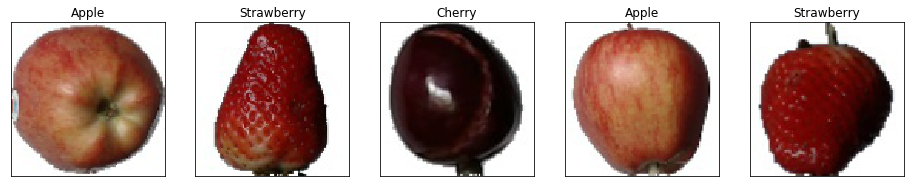

In [4]:
tr_img.show(randomize=True)

In [5]:
tr_img.image_summary

jpg                  2458
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel    126.034
min1stChannel           0
max1stChannel         255
mean2ndChannel    129.357
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    160.176
min3rdChannel           0
max3rdChannel         255
dtype: object

### Build a DLPy Sequential Model

In [6]:
model1 = Sequential(conn=s, model_table='Simple_CNN1')

model1.add(InputLayer(n_channels=3, width=100, height=100, scale=1, 
                      offsets=tr_img.channel_means))

model1.add(Conv2d(n_filters=6, width=5, height=5, stride=1, act='identity', 
                  include_bias=False))
model1.add(BN(act='relu'))
model1.add(Pooling(width=2, height=2, stride=2, pool='max'))

model1.add(Conv2d(n_filters=16, width=5, height=5, stride=1, act='identity',
                  include_bias=False))
model1.add(BN(act='relu'))
model1.add(Pooling(width=2, height=2, stride=2, pool='max'))

model1.add(Dense(n=120))
model1.add(Dense(n=84))

model1.add(OutputLayer(n=5))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [7]:
model1.print_summary()

,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,Input1,input,None,None,None,"(100, 100, 3)","(0, 0)"
1,Convo.1,convo,"(5, 5)",1,Identity,"(100, 100, 6)","(450, 0)"
2,B.N.1,batchnorm,None,None,Relu,"(100, 100, 6)","(0, 12)"
3,Pool1,pool,"(2, 2)",2,Max,"(50, 50, 6)","(0, 0)"
4,Convo.2,convo,"(5, 5)",1,Identity,"(50, 50, 16)","(2400, 0)"
5,B.N.2,batchnorm,None,None,Relu,"(50, 50, 16)","(0, 32)"
6,Pool2,pool,"(2, 2)",2,Max,"(25, 25, 16)","(0, 0)"
7,F.C.1,fc,"(10000, 120)",None,Relu,120,"(1200000, 0)"
8,F.C.2,fc,"(120, 84)",None,Relu,84,"(10080, 0)"
9,Output1,output,"(84, 5)",None,Softmax,5,"(420, 5)"


### Train the model

In [8]:
model1.fit(data=tr_img, 
           mini_batch_size=4, 
           max_epochs=7, 
           lr=1E-4, 
           gpu=Gpu(devices=[0]), 
           log_level=2)

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training from scratch.
NOTE: Only 1 out of 4 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 1213603.
NOTE:  The approximate memory cost is 53.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.47 (s).
NOTE:  The total number of threads on each worker is 12.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 48.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      5
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple     
NOTE:  Level      1: Cherry    
NOTE:  Level      2: Lemon     
NOTE:  Level      3: Raspberry 
NOTE:  Level      4: Strawberry
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch

,Descr,Value
0,Model Name,simple_cnn1
1,Model Type,Convolutional Neural Network
2,Number of Layers,10
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,2
8,Number of Batch Normalization Layers,2
9,Number of Weight Parameters,1213350


### Score Test Image

In [9]:
model1.evaluate(te_img)

NOTE: Due to data distribution, miniBatchSize has been limited to 1.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read             1
 1  Number of Observations Used             1
 2  Misclassification Error (%)             0
 3                   Loss Error      0.471783

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_8vdStW     1       12   
 
                                             casTable  
 0  CASTable('Valid_Res_8vdStW', caslib='CASUSER(s...  

+ Elapsed: 0.0557s, user: 0.128s, sys: 0.0413s, mem: 86.7mb

NOTE: Table TEMP_PLOT contains compressed images.
NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


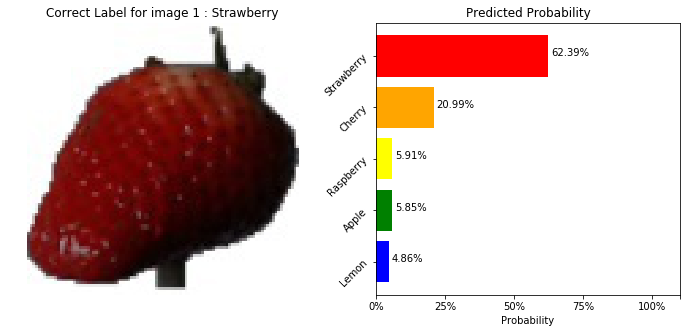

In [10]:
model1.plot_evaluate_res()

### Deploy to ONNX

First, save the weights in csv file

In [11]:
model1.save_weights_csv(path='/disk/linux/dlpy')

NOTE: Model weights csv saved successfully.


Deploy ONNX model

In [12]:
model1.deploy(path='/disk/linux/dlpy', output_format='onnx', model_weights='/disk/linux/dlpy/Simple_CNN1_weights.csv')

Using TensorFlow backend.


NOTE: Model weights will be loaded from csv.
NOTE: ONNX model file saved successfully.


## Run ONNX Model Using TensorFlow Backend

In [13]:
import onnx
import cv2
import numpy as np
import onnx_tf.backend

In [14]:
model = onnx.load('/disk/linux/dlpy/Simple_CNN1.onnx')

Import the ONNX model to TensorFlow

In [15]:
tf_rep = onnx_tf.backend.prepare(model)

### Load the Test Image and Preprocess

In [16]:
# load image and subtract channel means
img = cv2.imread('r_321_100.jpg')
img = np.transpose(img, (2, 0, 1))
img = np.reshape(img, (1, 3, 100, 100)).astype(np.float32)
img -= np.array(tr_img.channel_means).reshape(1, 3, 1, 1)

### Run the model

In [17]:
output = tf_rep.run(img)

Helper function to decode labels

In [18]:
CLASS_INDEX = {
    '0' : 'APPLE',
    '1' : 'CHERRY',
    '2' : 'LEMON',
    '3' : 'RASPBERRY',
    '4' : 'STRAWBERRY'
}
def decode_predictions(pred):
    results = []
    for p in pred:
        top_indices = p.argsort()[-5:][::-1]
        result = [(CLASS_INDEX[str(i)], p[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

In [19]:
decode_predictions(output[0])

[[('STRAWBERRY', 0.6288292),
  ('CHERRY', 0.20592886),
  ('RASPBERRY', 0.05912321),
  ('APPLE', 0.05799132),
  ('LEMON', 0.048127346)]]

# Run ONNX Model Using Caffe2 Backend

In [20]:
import caffe2.python.onnx.backend

In [21]:
caffe2_rep = caffe2.python.onnx.backend.prepare(model)

In [22]:
output = caffe2_rep.run(img)

In [23]:
decode_predictions(output[0])

[[('STRAWBERRY', 0.62882906),
  ('CHERRY', 0.20592895),
  ('RASPBERRY', 0.05912327),
  ('APPLE', 0.057991333),
  ('LEMON', 0.0481274)]]

In [24]:
s.endsession()

+ Elapsed: 0.000278s, user: 0.000195s, sys: 2.8e-05s, mem: 0.199mb